In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from ethograph.utils.io import TrialTree
import xarray as xr
from typing import Dict, List
from ethograph.utils.data_utils import ds_to_df, stack_trials
import matplotlib.pyplot as plt



paths = [r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250526_01\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250527_02\behav\Trial_data.nc",
         r"C:\Users\Admin\Documents\Akseli\AI_data\derivatives\sub-03_id-Freddy\ses-000_date-20250528_01\behav\Trial_data.nc"]
        

# 2019528keypoints
# 544952keypoints

# Usage
trees = {f"tree_{i}": TrialTree.load(p) for i, p in enumerate(paths)}
ds = stack_trials(trees, ["labels"], ["poscat", "num_pellets", "human_verified"])
df = ds_to_df(ds)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from ethograph.utils.paths import get_project_root
from ethograph.utils.labels import load_motif_mapping

mapping_path =  get_project_root() / "configs" / "mapping.txt"
mappings = load_motif_mapping(mapping_path)
mappings

{0: {'name': 'background',
  'color': array([0.00392157, 0.00392157, 0.00392157])},
 1: {'name': 'pullOutStick',
  'color': array([1.        , 0.4       , 0.69803922])},
 2: {'name': 'diagonalToBox',
  'color': array([0.4       , 0.61960784, 1.        ])},
 3: {'name': 'toss', 'color': array([0.6, 0.2, 1. ])},
 4: {'name': 'swoopLeftToCorner', 'color': array([1. , 0.2, 0.2])},
 5: {'name': 'reachToWall', 'color': array([0.4, 1. , 0.4])},
 6: {'name': 'right', 'color': array([1. , 0.6, 0.4])},
 7: {'name': 'pullOutPellet', 'color': array([0. , 0.6, 0. ])},
 8: {'name': 'swoopOut', 'color': array([0.        , 0.        , 0.50196078])},
 9: {'name': 'stickToDisp', 'color': array([1., 1., 0.])},
 10: {'name': 'stickInDisp', 'color': array([0. , 0.8, 0.8])},
 11: {'name': 'rightToPellet',
  'color': array([0.50196078, 0.50196078, 0.        ])},
 12: {'name': 'snapPellet', 'color': array([1., 0., 1.])},
 13: {'name': 'eat', 'color': array([1.        , 0.64705882, 0.        ])},
 14: {'name':

2026-01-14 11:11:53.565 | WARNING  | pandas.core.groupby.groupby:apply:1832 - C:\Users\Admin\AppData\Local\Temp\ipykernel_17232\1321908714.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

2026-01-14 11:11:53.565 | WARNING  | pandas.core.frame:_getitem_bool_array:4148 - C:\Users\Admin\AppData\Local\Temp\ipykernel_17232\1321908714.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style.mplstyle'), line 10 ('font.size: 13')

B

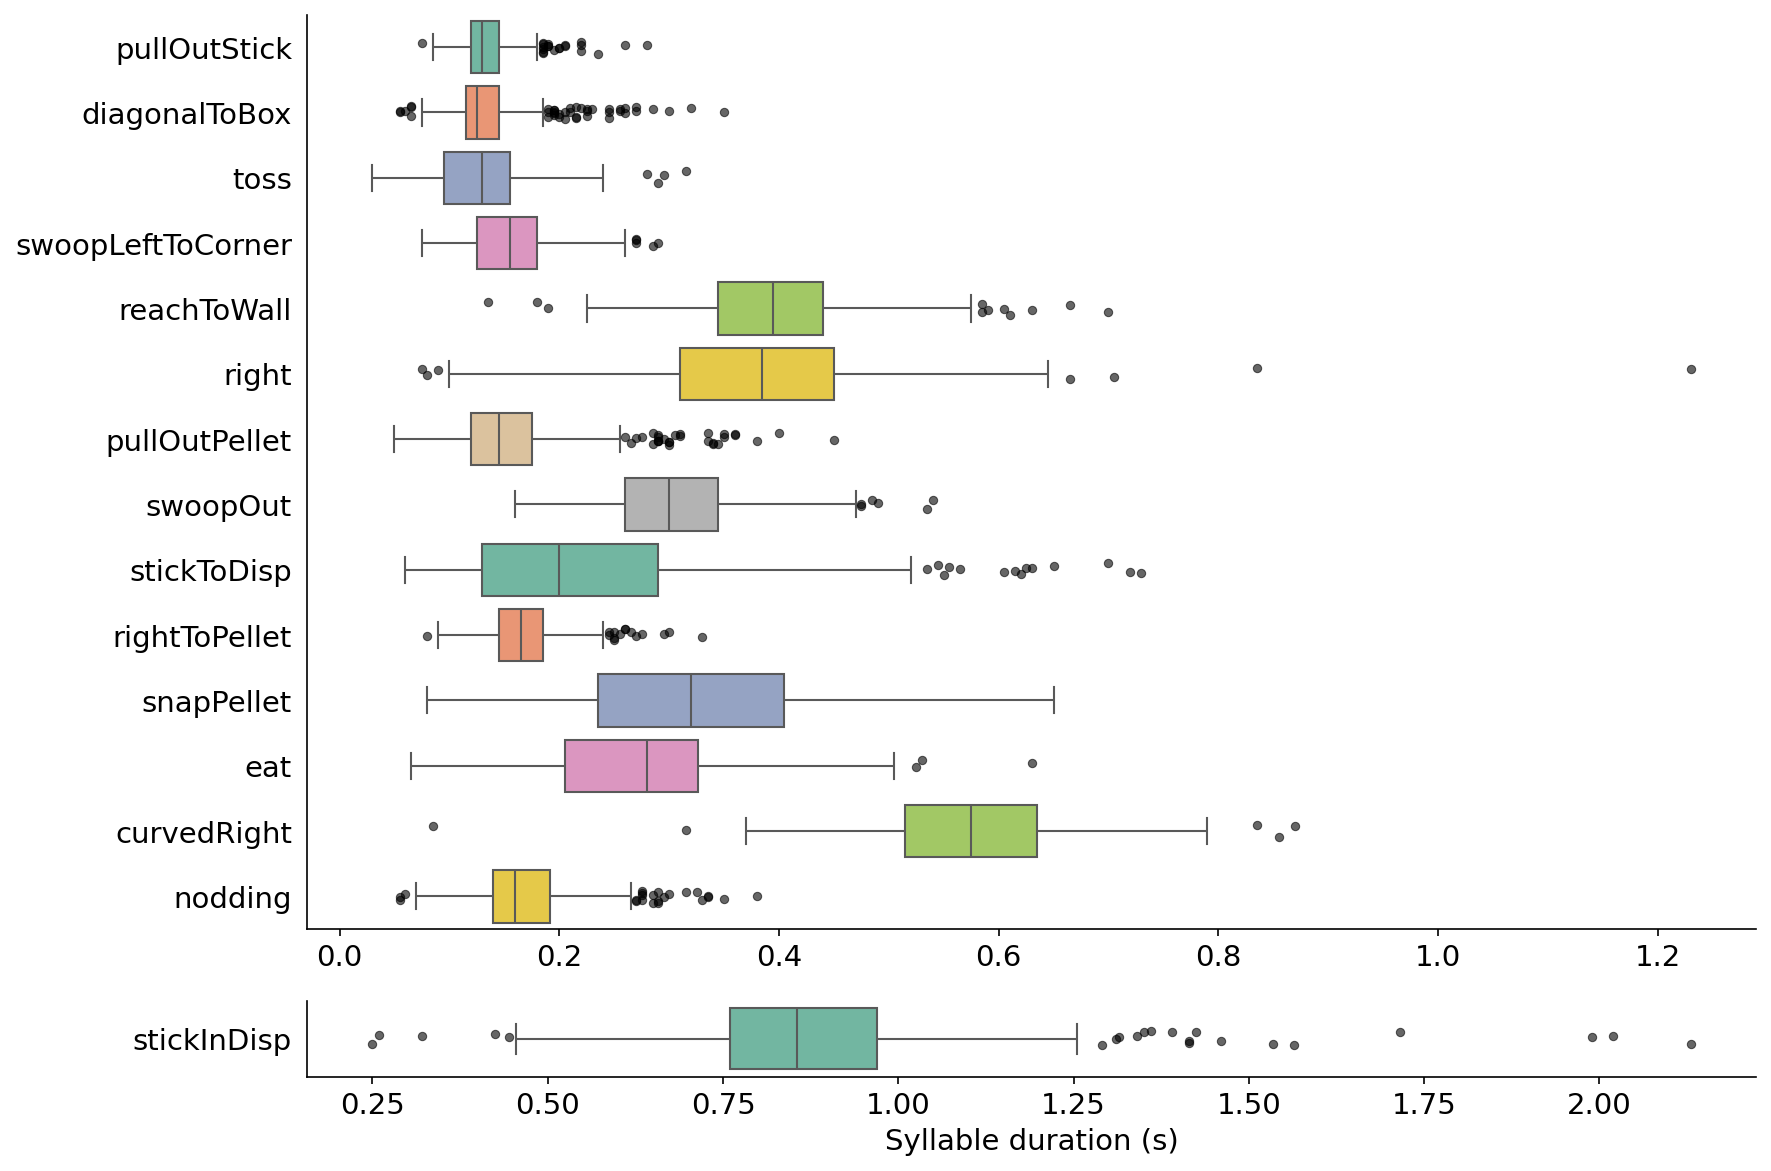

In [24]:

def mark_outliers(group):
    q1 = group['duration'].quantile(0.25)
    q3 = group['duration'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (group['duration'] < lower) | (group['duration'] > upper)

df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]

from ethograph.utils.paths import get_project_root
from ethograph.utils.labels import load_motif_mapping

mapping_path =  get_project_root() / "configs" / "mapping.txt"
mappings = load_motif_mapping(mapping_path)
style_sheet = get_project_root() / "configs" / "style.mplstyle"
plt.style.use(style_sheet)



label_long = 10

df_main = df[df['label'] != label_long]
df_out_main = df_outliers[df_outliers['label'] != label_long]

df_long = df[df['label'] == label_long]
df_out_long = df_outliers[df_outliers['label'] == label_long]

fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    gridspec_kw={'height_ratios': [12, 1]},  # bottom smaller
    sharex=False
)

# ── TOP: all normal labels ─────────────────────────────
sns.boxplot(
    data=df_main,
    x='duration',
    y='label',
    orient='h',
    ax=ax1,
    palette='Set2',
    showfliers=False
)

sns.stripplot(
    data=df_out_main,
    x='duration',
    y='label',
    orient='h',
    ax=ax1,
    color='black',
    size=4,
    alpha=0.6,
    linewidth=0.5
)



# ── BOTTOM: label 10 only ───────────────────────────────
sns.boxplot(
    data=df_long,
    x='duration',
    y='label',
    orient='h',
    ax=ax2,
    palette='Set2',
    showfliers=False
)

sns.stripplot(
    data=df_out_long,
    x='duration',
    y='label',
    orient='h',
    ax=ax2,
    color='black',
    size=4,
    alpha=0.6,
    linewidth=0.5
)


ax1.set_ylabel('')
ax2.set_ylabel('')

# ── Replace numeric labels with motif names ─────────────
label_to_name = {k: v['name'] for k, v in mappings.items()}

# Top subplot labels
ylabels = [int(t.get_text()) for t in ax1.get_yticklabels()]
ax1.set_yticklabels([label_to_name[l] for l in ylabels])

# Bottom subplot label
ax2.set_yticklabels([label_to_name[label_long]])

ax1.set_xlabel('')
ax2.set_xlabel('Syllable duration (s)'
               
               )

# ── Remove plot boxes (spines) ─────────────────────────
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

remove_spines(ax1)
remove_spines(ax2)

ax1.tick_params(left=False)
ax2.tick_params(left=False)

plt.tight_layout()
plt.show()